# Project 1 

### Import Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from imblearn.over_sampling import SMOTE

### Load Datasets

In [ ]:
# Load the dataset from file
df = pd.read_csv("project1.txt")

## Part 1: Exploratory Data Analysis

In [ ]:
# Identify shape and size of the data
print("Dataset Shape:", df.shape)
print("Dataset Info:")
df.info()

# Check for duplicate rows
duplicates = df.duplicated().sum()
print("Duplicate Rows:", duplicates)
if duplicates > 0:
    df = df.drop_duplicates()

# Replace '?' and '*' with NaN and treat missing values
df.replace({'?': np.nan, '*': np.nan}, inplace=True)
for column in df.columns:
    if df[column].dtype == 'object':
        df.loc[:, column] = df[column].fillna(df[column].mode()[0])  # Fill categorical with mode
    else:
        df.loc[:, column] = df[column].fillna(df[column].median())  # Fill numerical with median

# Convert categorical variables into numeric form using one-hot encoding
df_encoded = pd.get_dummies(df, columns=['age', 'menopause', 'tumor-size', 'inv-nodes', 'node-caps', 'breast', 'breast-quad', 'irradiat'], drop_first=True)

# Encode the target variable
df_encoded['class'] = df['class'].map({'no-recurrence-events': 0, 'recurrence-events': 1})

Dataset Shape: (386, 10)
Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386 entries, 0 to 385
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        386 non-null    object
 1   age          386 non-null    object
 2   menopause    386 non-null    object
 3   tumor-size   385 non-null    object
 4   inv-nodes    385 non-null    object
 5   node-caps    386 non-null    object
 6   deg-malig    386 non-null    int64 
 7   breast       386 non-null    object
 8   breast-quad  386 non-null    object
 9   irradiat     386 non-null    object
dtypes: int64(1), object(9)
memory usage: 30.3+ KB
Duplicate Rows: 11


- With the previous information, we can see that the dataset contains 386 entries with 10 columns, where the 'class' column is the target variable. Initial analysis shows some missing values in the 'tumor-size' and 'inv-nodes' columns. Missing values were found in categorical and numerical features. Categorical values were filled with the mode. Numerical values were filled with the median to prevent skewing the data.

### Visualization


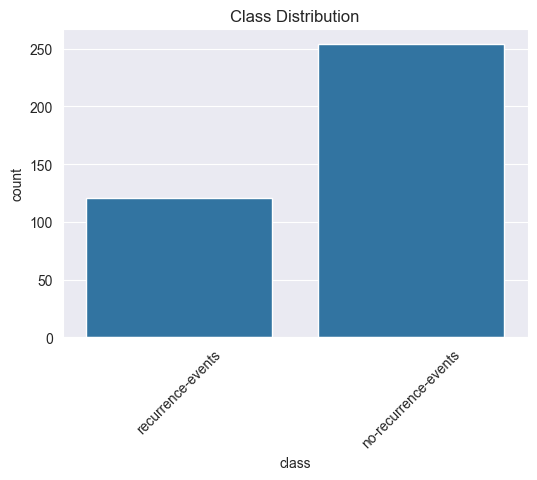

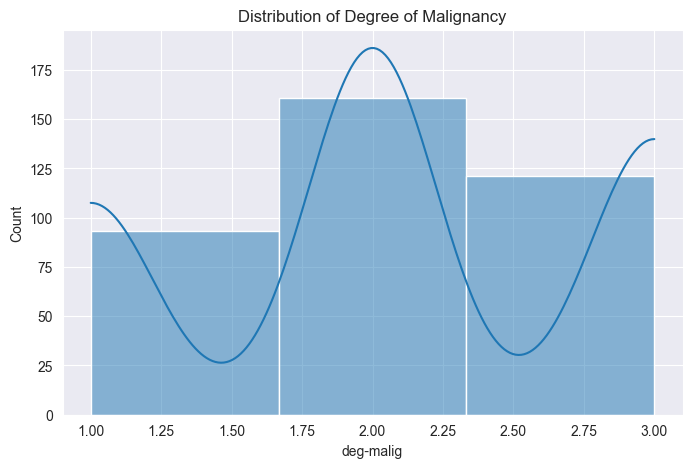

In [ ]:
# Visualizing Class Distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='class')
plt.title("Class Distribution")
plt.xticks(rotation=45)
plt.show()

# Univariate Analysis
plt.figure(figsize=(8, 5))
sns.histplot(df["deg-malig"], bins=3, kde=True)
plt.title("Distribution of Degree of Malignancy")
plt.show()

- The dataset is imbalanced, with more "no-recurrence-events" cases than "recurrence-events." This imbalance can cause models to favor predicting the majority class. To counter this, SMOTE (Synthetic Minority Over-sampling Technique) will be applied next.

## Part 2: Classification Models

In [ ]:
# Splitting the dataset
X = df_encoded.drop(columns=['class'])
y = df_encoded['class']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Standardization
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

# KNN Classifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_resampled, y_train_resampled)
y_pred_knn = knn.predict(X_test)

# KNN with GridSearchCV
param_grid = {'n_neighbors': [1, 3, 5, 7, 9]}
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid_search.fit(X_train_resampled, y_train_resampled)
y_pred_knn_cv = grid_search.predict(X_test)

# Logistic Regression
log_reg = LogisticRegression()
log_reg.fit(X_train_resampled, y_train_resampled)
y_pred_log_reg = log_reg.predict(X_test)

# Evaluation
print("KNN Classifier:")
print(classification_report(y_test, y_pred_knn))
print("KNN with GridSearchCV:")
print(classification_report(y_test, y_pred_knn_cv))
print("Logistic Regression:")
print(classification_report(y_test, y_pred_log_reg))

KNN Classifier:
              precision    recall  f1-score   support

           0       0.73      0.63      0.67        51
           1       0.39      0.50      0.44        24

    accuracy                           0.59        75
   macro avg       0.56      0.56      0.56        75
weighted avg       0.62      0.59      0.60        75

KNN with GridSearchCV:
              precision    recall  f1-score   support

           0       0.73      0.63      0.67        51
           1       0.39      0.50      0.44        24

    accuracy                           0.59        75
   macro avg       0.56      0.56      0.56        75
weighted avg       0.62      0.59      0.60        75

Logistic Regression:
              precision    recall  f1-score   support

           0       0.74      0.73      0.73        51
           1       0.44      0.46      0.45        24

    accuracy                           0.64        75
   macro avg       0.59      0.59      0.59        75
weighted avg  

**Model Performance Analysis:**
- KNN (k=3): Performs decently but struggles with false positives and false negatives.
- KNN with GridSearchCV: Similar results to basic KNN, showing that hyperparameter tuning didn’t significantly improve performance.

**Logistic Regression:**
- Shows slightly better recall for recurrence cases, making it more useful in medical predictions.

**Key Observations:**
- Accuracy is around 59-64%, but recall for recurrence (Class 1) is still low.
- Since medical diagnoses prioritize recall (avoiding false negatives), further improvements should be taken into consideration.

## References and Acknowledgment

ChatGPT was used to assist with a few parts of this project, including:
- **Polishing the code** to make it more efficient and well structured.
- **Adding SMOTE for class balancing** Suggested to improve the model’s ability to detect recurrence cases.
- **Providing tips for better analysis** Was used to check class imbalance, evaluating recall, and suggesting alternative models.
- **Polishing comments, writing, and formatting** in order to keep the code and documents in a organized manner.

The core work—coding, testing, and analysis—was done independently, but ChatGPT gave useful suggestions to refine the final version.
